<a href="https://colab.research.google.com/github/Karasiari/Graphs/blob/main/ForExps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install "git+https://github.com/Karasiari/graphmcfexps.git"

  Cloning https://github.com/Karasiari/graphmcfexps.git to /tmp/pip-req-build-axhh0y8y
  Running command git clone --filter=blob:none --quiet https://github.com/Karasiari/graphmcfexps.git /tmp/pip-req-build-axhh0y8y
  Resolved https://github.com/Karasiari/graphmcfexps.git to commit f5aaefbae2426268b5c45f1b77ed459571336cb9
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for graphmcfexps: filename=graphmcfexps-0.1.0-py3-none-any.whl size=10126 sha256=5b08b604d5920ee57877ae8e20e07c1ff512655d493765caddccbc3f6cadfc64
  Stored in directory: /tmp/pip-ephem-wheel-cache-uv5yev_3/wheels/09/cf/d5/20f73fe3b91fddd32c1c90d1bb788e0d83851f63661cafc4ad
Successfully built graphmcfexps


In [2]:
import pandas as pd
import numpy as np
import os # Выберите, откуда тяните папку
from google.colab import files

BITRATE_DENOMINATOR = 100

# По папке формируем словарь графов со структурой -
#                                                {'название графа (как в папке)':
#                                                       {'adj_edges': список мультиребер смежности со значением capacity мультиребра,
#                                                        'traffic_edges': список мультребер запросов со значением weight мультиребра,
#                                                }

def csv_to_graph(path, demands_path, capacity_path):
  Df = pd.read_csv(path, header=None, names = ['id', 'source', 'target', 'length'])
  Traffic = pd.read_csv(demands_path, header=None, names = ['id', 'source', 'target', 'bitrate'])
  Capacity = pd.read_csv(capacity_path, header=None, names = ['name', 'value'])
  df = Df.iloc[1:].copy()
  traffic = Traffic.iloc[1:].copy()
  capacity = Capacity.iloc[1:].copy()

  df['source'] = df['source'].astype(int)
  df['target'] = df['target'].astype(int)
  traffic['source'] = traffic['source'].astype(int)
  traffic['target'] = traffic['target'].astype(int)
  traffic['bitrate'] = traffic['bitrate'].astype(int) // BITRATE_DENOMINATOR
  capacity_value = (float(capacity[capacity['name']=='LineRate']['value']) // BITRATE_DENOMINATOR) * int(capacity[capacity['name']=='NumberOfWavelengths']['value'])

  sources = df['source'].tolist()
  targets = df['target'].tolist()
  sources_traffic = traffic['source'].tolist()
  targets_traffic = traffic['target'].tolist()
  bitrates_traffic = traffic['bitrate'].tolist()

  unique_vertices = set()
  for source, target in zip(sources, targets):
    unique_vertices.add(source)
    unique_vertices.add(target)
  vertex_mapping = {old: new for new, old in enumerate(unique_vertices)}
  num_vertices = len(unique_vertices)

  adj_edges = []
  traffic_edges = []

  for source, target in zip(sources, targets):
    new_source = vertex_mapping[source]
    new_target = vertex_mapping[target]
    adj_edges.append((new_source, new_target, {"capacity": capacity_value}))
  for source, target, bitrate in zip(sources_traffic, targets_traffic, bitrates_traffic):
    new_source = vertex_mapping[source]
    new_target = vertex_mapping[target]
    traffic_edges.append((new_source, new_target, {"weight": bitrate}))

  return (adj_edges, traffic_edges)

def get_graphs(base_path, specified_graphs, specified):
  Graphs = {}
  csv_tables = []
  for folder_name in os.listdir(base_path):
    if folder_name in specified_graphs or not specified:
      folder_path = os.path.join(base_path, folder_name)
      csv_path = os.path.join(folder_path, 'links.csv')
      csv_path_demands = os.path.join(folder_path, 'demands.csv')
      csv_path_capacity = os.path.join(folder_path, 'params.csv')
      csv_tables.append(folder_name)

      (adj_edges, traffic_edges) = csv_to_graph(csv_path, csv_path_demands, csv_path_capacity)
      Graphs[folder_name] = {'adj_edges': adj_edges, 'traffic_edges': traffic_edges}

  return Graphs

path_to_folder = '/content/drive/MyDrive/Кола' # Свой путь

In [10]:
small_graphs_for_test_names = ['cola_t7']
small_graphs_for_test = get_graphs(path_to_folder, small_graphs_for_test_names, True)

/tmp/ipython-input-3657628743.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  capacity_value = (float(capacity[capacity['name']=='LineRate']['value']) // BITRATE_DENOMINATOR) * int(capacity[capacity['name']=='NumberOfWavelengths']['value'])
/tmp/ipython-input-3657628743.py:27: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  capacity_value = (float(capacity[capacity['name']=='LineRate']['value']) // BITRATE_DENOMINATOR) * int(capacity[capacity['name']=='NumberOfWavelengths']['value'])


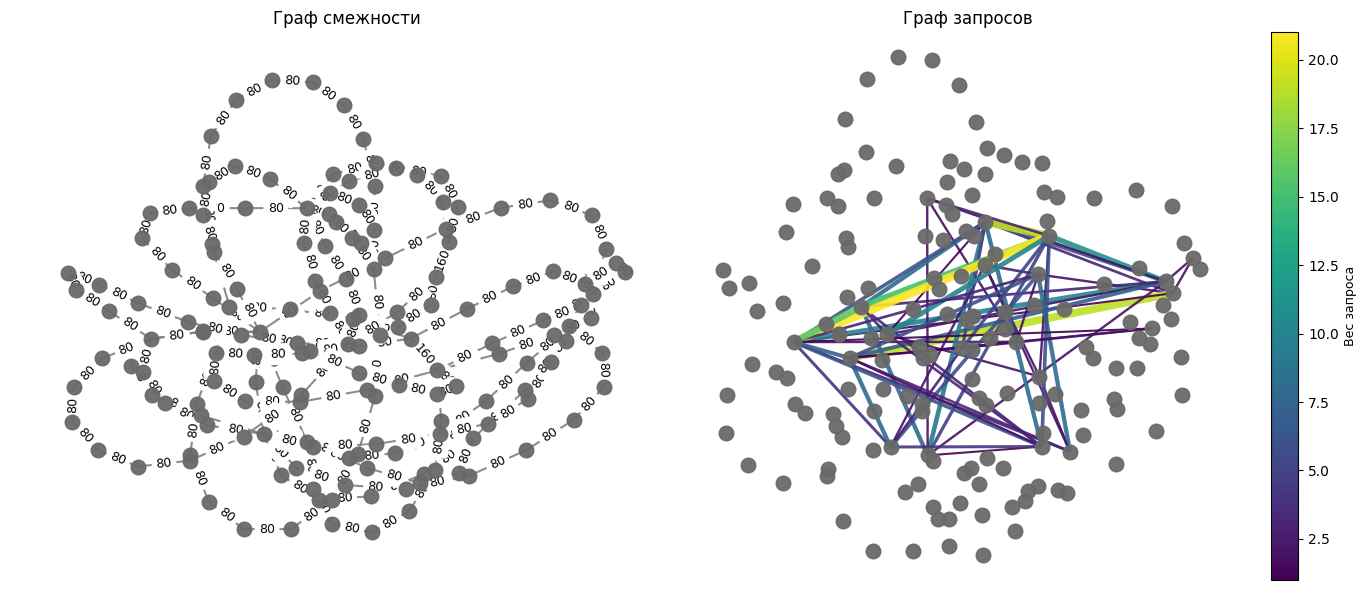

MCFP solution for gamma: 2.5196850391816925

MCF solved with eps=0.1: True


In [13]:
from graphmcfexps import GraphMCFexps
import networkx as nx

for name, graph in small_graphs_for_test.items():
  adj_edges, traffic_edges = graph['adj_edges'], graph['traffic_edges']
  adj_graph = nx.MultiGraph()
  adj_graph.add_edges_from(adj_edges)
  traffic_graph = nx.MultiDiGraph()
  traffic_graph.add_nodes_from(range(adj_graph.number_of_nodes()))
  traffic_graph.add_edges_from(traffic_edges)
  test = GraphMCFexps(adj_graph, traffic_graph)

  test.visualise_with_demands(version="current")
  test.solve_mcfp()
  eps = 0.1
  test.solve_mcf(eps=eps)
  print(f'MCFP solution for gamma: {test.gamma}\n')
  print(f'MCF solved with eps={eps}: {test.mcf_solved}')